In [48]:
import os
from datetime import datetime
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [41]:
from pandas import read_csv
from datetime import datetime
# load data
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')
dataset = read_csv('raw.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)
# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
dataset = dataset[24:]
# summarize first 5 rows
print(dataset.head(5))
# save to file
dataset.to_csv('pollution.csv')

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


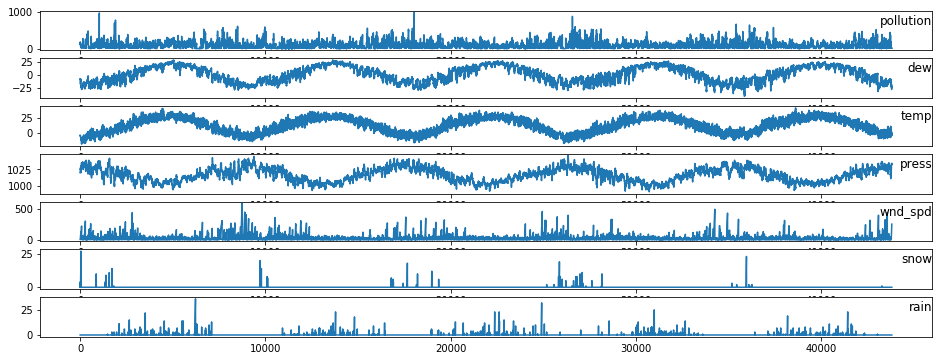

In [42]:
from matplotlib import pyplot
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
pyplot.figure(figsize=(16,6))
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()

In [43]:
# convert series to supervised learning
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from pandas import DataFrame
from pandas import concat

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
2   0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
3   0.159960   0.426471   0.229508   0.545454   0.666667   0.005332   
4   0.182093   0.485294   0.229508   0.563637   0.666667   0.008391   
5   0.138833   0.485294   0.229508   0.563637   0.666667   0.009912   

   var7(t-1)  var8(t-1)   var1(t)  
1   0.000000        0.0  0.148893  
2   0.000000        0.0  0.159960  
3   0.000000        0.0  0.182093  
4   0.037037        0.0  0.138833  
5   0.074074        0.0  0.109658  


In [50]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 1, 8) (8760,) (35039, 1, 8) (35039,)


Train on 8760 samples, validate on 35039 samples
Epoch 1/50
2s - loss: 0.0574 - val_loss: 0.0576
Epoch 2/50
1s - loss: 0.0419 - val_loss: 0.0656
Epoch 3/50
1s - loss: 0.0262 - val_loss: 0.0580
Epoch 4/50
1s - loss: 0.0174 - val_loss: 0.0477
Epoch 5/50
1s - loss: 0.0162 - val_loss: 0.0355
Epoch 6/50
1s - loss: 0.0153 - val_loss: 0.0252
Epoch 7/50
1s - loss: 0.0150 - val_loss: 0.0219
Epoch 8/50
1s - loss: 0.0149 - val_loss: 0.0194
Epoch 9/50
1s - loss: 0.0148 - val_loss: 0.0169
Epoch 10/50
1s - loss: 0.0147 - val_loss: 0.0156
Epoch 11/50
1s - loss: 0.0146 - val_loss: 0.0154
Epoch 12/50
1s - loss: 0.0147 - val_loss: 0.0146
Epoch 13/50
1s - loss: 0.0146 - val_loss: 0.0142
Epoch 14/50
1s - loss: 0.0147 - val_loss: 0.0139
Epoch 15/50
1s - loss: 0.0145 - val_loss: 0.0140
Epoch 16/50
1s - loss: 0.0145 - val_loss: 0.0136
Epoch 17/50
1s - loss: 0.0145 - val_loss: 0.0140
Epoch 18/50
1s - loss: 0.0147 - val_loss: 0.0135
Epoch 19/50
1s - loss: 0.0146 - val_loss: 0.0136
Epoch 20/50
1s - loss: 0.0147

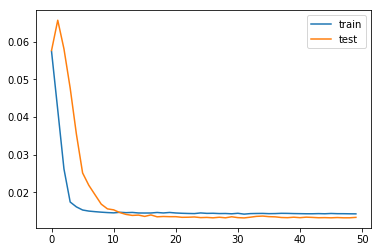

In [45]:
# design network
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [49]:
# make a prediction
from numpy import concatenate

yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 26.348


In [75]:
data  = scaled
n_vars = 1 if type(data) is list else data.shape[1]
df = DataFrame(data)
cols, names = list(), list()
# input sequence (t-n, ... t-1)
for i in range(3, 0, -1):
    cols.append(df.shift(i))
    names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
# forecast sequence (t, t+1, ... t+n)
for i in range(0, 1):
    cols.append(df.shift(-i))
    if i == 0:
        names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    else:
        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
# put it all together
agg = concat(cols, axis=1)
agg.columns = names
# drop rows with NaN values
# if dropnan:
#     agg.dropna(inplace=True)

In [77]:
reframed = series_to_supervised(scaled, 3, 1)

In [84]:
n_hours = 3
n_features = 8
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)

# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)

(8760, 24) 8760 (8760,)


In [82]:
reframed

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var7(t-3),var8(t-3),var1(t-2),var2(t-2),...,var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
3,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893,0.367647,...,0.000000,0.0,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0
4,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960,0.426471,...,0.037037,0.0,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0
5,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093,0.485294,...,0.074074,0.0,0.109658,0.485294,0.213115,0.563637,0.666667,0.011433,0.111111,0.0
6,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833,0.485294,...,0.111111,0.0,0.105634,0.485294,0.213115,0.581818,0.666667,0.014492,0.148148,0.0
7,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658,0.485294,...,0.148148,0.0,0.124748,0.485294,0.229508,0.600000,0.666667,0.017551,0.000000,0.0
8,0.109658,0.485294,0.213115,0.563637,0.666667,0.011433,0.111111,0.0,0.105634,0.485294,...,0.000000,0.0,0.120724,0.470588,0.213115,0.600000,0.666667,0.020610,0.000000,0.0
9,0.105634,0.485294,0.213115,0.581818,0.666667,0.014492,0.148148,0.0,0.124748,0.485294,...,0.000000,0.0,0.132797,0.485294,0.229508,0.618183,0.666667,0.023669,0.000000,0.0
10,0.124748,0.485294,0.229508,0.600000,0.666667,0.017551,0.000000,0.0,0.120724,0.470588,...,0.000000,0.0,0.140845,0.485294,0.229508,0.636364,0.666667,0.029018,0.037037,0.0
11,0.120724,0.470588,0.213115,0.600000,0.666667,0.020610,0.000000,0.0,0.132797,0.485294,...,0.037037,0.0,0.152918,0.470588,0.229508,0.636364,0.666667,0.034367,0.000000,0.0
12,0.132797,0.485294,0.229508,0.618183,0.666667,0.023669,0.000000,0.0,0.140845,0.485294,...,0.000000,0.0,0.148893,0.470588,0.229508,0.636364,0.666667,0.039716,0.000000,0.0


In [85]:
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 3, 8) (8760,) (35037, 3, 8) (35037,)


In [86]:
train_X[0]

array([[ 0.12977867,  0.35294122,  0.24590163,  0.52727318,  0.66666669,
         0.00229001,  0.        ,  0.        ],
       [ 0.14889336,  0.36764708,  0.24590163,  0.52727318,  0.66666669,
         0.00381099,  0.        ,  0.        ],
       [ 0.15995975,  0.42647061,  0.22950819,  0.54545403,  0.66666669,
         0.00533197,  0.        ,  0.        ]], dtype=float32)